In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets

In [2]:
def accu(out, y):
    _, pred = torch.max(out, 1)  # 最大概率，对应的类别
    corr_num = pred.eq(y).sum()  # tensor 得取出结果
    acc = corr_num.item() / y.shape[0]
    return acc

def train(model, device, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = model(x)               # 各个分类的概率
        loss = criterion(out, y)
        train_loss += loss.item()
        acc = accu(out, y)
        train_acc += acc
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader), train_acc / len(train_loader) 

def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x) 
            loss = criterion(out, y)
            test_loss += loss.item()
            acc = accu(out, y)
            test_acc += acc
    return test_loss/len(test_loader), test_acc/len(test_loader)

def modify_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        print("Before modify lr is:", param_group["lr"])
        param_group["lr"] = lr
        print("After modify lr is:", param_group["lr"])

In [3]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Inception(nn.Module):
    def __init__(self, in_channel, n1_1, n3x3red, n3x3, n5x5red, n5x5, pool_plane):
        super(Inception, self).__init__()
        # first line
        self.branch1x1 = BasicConv2d(in_channel, n1_1, kernel_size=1)

        # second line
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channel, n3x3red, kernel_size=1),
            BasicConv2d(n3x3red, n3x3, kernel_size=3, padding=1)
        )

        # third line
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channel, n5x5red, kernel_size=1),
            BasicConv2d(n5x5red, n5x5, kernel_size=5, padding=2)
        )

        # fourth line
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            BasicConv2d(in_channel, pool_plane, kernel_size=1)
        )

    def forward(self, x):
        y1 = self.branch1x1(x)
        y2 = self.branch3x3(x)
        y3 = self.branch5x5(x)
        y4 = self.branch_pool(x)
        output = torch.cat([y1, y2, y3, y4], 1)
        return output


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)

        self.max_pool1 = nn.MaxPool2d(3, stride=2)

        self.conv2 = BasicConv2d(64, 192, kernel_size=3, stride=1, padding=1)

        self.max_pool2 = nn.MaxPool2d(3, stride=2)

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.max_pool3 = nn.MaxPool2d(3, stride=2)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.max_pool4 = nn.MaxPool2d(3, stride=2)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avg_pool = nn.AvgPool2d(7)

        self.dropout = nn.Dropout(0.4)

        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.max_pool3(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.max_pool4(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avg_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [4]:
batch_size = 32
epochs = 100

In [5]:
data_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

data_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
])

In [6]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=data_trans)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=data_trans)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
n_train = int(len(train_data)*0.9)
n_valid = len(train_data) - n_train
train_datasets, valid_datasets = torch.utils.data.random_split(train_data, [n_train, n_valid])

train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_datasets, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogLeNet(10)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    model = model.to(device)
else:
    model = model.to(device)

In [9]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()

In [10]:
model_path = './models/googlenet-sifar10.pth'
best_valid_loss = float("inf")
info = 'Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'
for epoch in range(epochs):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, device, valid_loader, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
    if (epoch+1) == 50:
        modify_lr(optimizer, lr=1e-2)
    if (epoch+1) == 80:
        modify_lr(optimizer, lr=1e-3)
    print(info.format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))

Epoch:1|Train Loss:1.6702552531404367|Train Acc:0.3937455579246624|Val Loss:1.5274906682360703|Val Acc:0.46078821656050956
Epoch:2|Train Loss:1.1684414563699232|Train Acc:0.5947050461975835|Val Loss:1.1361543710824031|Val Acc:0.6011146496815286
Epoch:3|Train Loss:0.9392321138154893|Train Acc:0.6795264747690121|Val Loss:0.8806839351821097|Val Acc:0.6932722929936306
Epoch:4|Train Loss:0.8069233792041665|Train Acc:0.7270344705046198|Val Loss:0.8533581064385214|Val Acc:0.7151671974522293
Epoch:5|Train Loss:0.7247118050948728|Train Acc:0.7534648187633263|Val Loss:0.6328939851492074|Val Acc:0.7878184713375797
Epoch:6|Train Loss:0.6583590377029495|Train Acc:0.7781405472636815|Val Loss:0.6314234974657654|Val Acc:0.7878184713375797
Epoch:7|Train Loss:0.6058666593399807|Train Acc:0.7950870646766169|Val Loss:0.655844840274495|Val Acc:0.7768710191082803
Epoch:8|Train Loss:0.558272251410525|Train Acc:0.812322316986496|Val Loss:0.4692033740935052|Val Acc:0.839171974522293
Epoch:9|Train Loss:0.522670

Epoch:68|Train Loss:0.024063542379329794|Train Acc:0.9929815209665956|Val Loss:0.2844030125315782|Val Acc:0.9257563694267515
Epoch:69|Train Loss:0.022064615922696047|Train Acc:0.9935145700071073|Val Loss:0.28310611378994716|Val Acc:0.9287420382165605
Epoch:70|Train Loss:0.023809310077943104|Train Acc:0.9926261549395877|Val Loss:0.28734084683808553|Val Acc:0.9249601910828026
Epoch:71|Train Loss:0.02319880597711711|Train Acc:0.9927149964463398|Val Loss:0.29216901981716703|Val Acc:0.923765923566879
Epoch:72|Train Loss:0.02266960712871233|Train Acc:0.9926927860696517|Val Loss:0.2901731802115015|Val Acc:0.9223726114649682
Epoch:73|Train Loss:0.0217942691222098|Train Acc:0.9932480454868514|Val Loss:0.30686724518135094|Val Acc:0.9197850318471338
Epoch:74|Train Loss:0.02288214326985101|Train Acc:0.9933590973702914|Val Loss:0.30115630197676885|Val Acc:0.9221735668789809
Epoch:75|Train Loss:0.02367630368462673|Train Acc:0.9933813077469794|Val Loss:0.27258458648137984|Val Acc:0.9235668789808917
E

## 图片
### inceptionv1参数表
- ![image](http://images.cnblogs.com/cnblogs_com/zingp/1384487/o_inceptionv1.png)

In [40]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [46]:
class ModelEval(object):
    def __init__(self, model, device, iter_loader, criterion, num_classes):
        self.model = model
        self.device = device
        self.iter_loader = iter_loader
        self.criterion =  criterion
        self.num_classes = num_classes
        self.prediction = []
        self.groundtruth = []
        self.gt_one_hot = []
        self.predscore = []
        self.fpr = dict()
        self.tpr = dict()
        self.roc_auc = dict()
    
    def evaluate(self):
        self.model.eval()
        epoch_loss = 0.0
        epoch_acc = 0.0
        iter_len = len(self.iter_loader)
        with torch.no_grad():
            for x, y in self.iter_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                out = self.model(x) 
                self.prediction.append(out)
                self.groundtruth.append(y)
                loss = self.criterion(out, y)
                epoch_loss += loss.item()
                acc = accu(out, y)
                epoch_acc += acc
        return epoch_loss/iter_len, epoch_acc/iter_len
    
    def get_loss_acc(self):
        return self.evaluate()
            
    def gt_and_predscore(self):
        if len(self.prediction) == 0:
            _, _ = self.evaluate()
        pred = torch.cat(self.prediction).cpu().numpy()   
        gt = torch.cat(self.groundtruth).cpu().numpy()
        # np.eye()就是拉成one_hot形式， groundtruth的onehot化
        self.gt_one_hot = np.eye(self.num_classes)[gt.reshape(-1)]   
        # softmax比叙事tensor格式
        self.predscore = F.softmax(torch.cat(self.prediction).cpu(), dim=1).cpu().numpy()
        
    def plt_roc(self):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        if len(self.gt_one_hot) == 0:
            self.gt_and_predscore()
        
        fpr['micro'], tpr['micro'], _ = roc_curve(self.gt_one_hot.ravel(), self.predscore.ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(self.gt_one_hot[:, i], self.predscore[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        for i in range(self.num_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC class %d AUC %0.2f'%(i, roc_auc[i]))
        
        plt.plot(fpr['micro'], tpr['micro'], lw=5, linestyle=":", label='ROC Micro AUC %0.2f'%(roc_auc['micro']))
        plt.legend()
        
    def plt_pr(self):
        prc = dict()
        rcl = dict()
        ap = dict()
        if len(self.gt_one_hot) == 0:
            self.gt_and_predscore()
        prc['micro'], rcl['micro'], _ = precision_recall_curve(self.gt_one_hot.ravel(), self.predscore.ravel())
        ap['micro'] = average_precision_score(self.gt_one_hot.ravel(), self.predscore.ravel(), average='micro')
        for i in range(self.num_classes):
            prc[i], rcl[i], _ = precision_recall_curve(self.gt_one_hot[:,i], self.predscore[:,i])
            ap[i] = average_precision_score(self.gt_one_hot[:,i], self.predscore[:,i])
        for i in range(self.num_classes):
            plt.plot(rcl[i], prc[i], lw=2, label='PR class %d Area %0.2f'%(i,ap[i]))
        plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Area %0.2f'%(ap['micro']))
        plt.legend()  

In [47]:
obj = ModelEval(model, device, test_loader, criterion, num_classes=10)

In [48]:
obj.get_loss_acc()

(0.319135738066591, 0.9189297124600639)

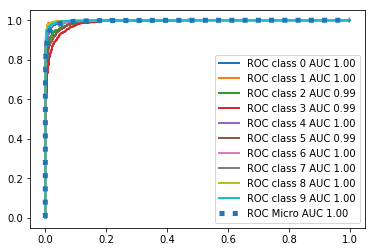

In [49]:
obj.plt_roc()

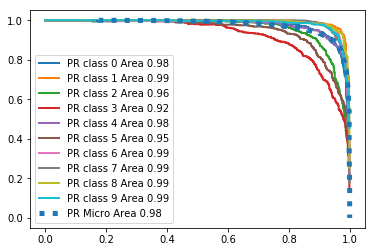

In [50]:
obj.plt_pr()

In [52]:
torch.save(model, model_path)

/root/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type GoogLeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type BasicConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Inception. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


AttributeError: 'DataParallel' object has no attribute '__name__'